# Cross Validation Example

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import scripts.load_data as load

import seaborn as sns

%matplotlib inline

In [2]:
import sklearn.linear_model
from sklearn.model_selection import train_test_split

In [3]:
X, y = load.load_training_spectra()

In [4]:
wavenumbers = [float(column) for column in X.columns]

output_columns = ["Ca","P","pH","SOC","Sand"]

#### Linear regression on the entire dataset gets a perfect score!

The cell below runs linear regression on the full dataset and then computes the score . The score is in terms of $R^2$, which is the fraction of squared error we remove by using our prediction instead of just predicting the average value for each output, ignoring the input data. A perfect score is therefore $1$, the score of our baseline model is $0$, and really terrible models, like always guessing $-100$, get negative scores.

In [5]:
model = sklearn.linear_model.LinearRegression()

model.fit(X,y)

print(model.score(X,y))

1.0


#### But cross-validation shows that the generalization is not great

The cell below runs `numSplits` iterations of cross-validation with an 80-20 train-test split. It uses the `train_test_split` function from `sklearn.model_selection`.

The cell beneath it plots the results using `distplot`.

The difference between the error on the training set and the error on the test set is called the "generalization error", since it arises from us learning the specificities of the training set -- properties that don't generalize to unseen data.

In [6]:
scores = []

numSplits = 50


for split in range(numSplits):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,) #this is using random splits, which is worse than
    #using all the data. this is not a cost effective way to do cross validation. you have to do it 50 times to get
    #a representative number for how good your regressor is. but you can just do kfold cross validation 5 times.
    #also k-fold evaluates on every point in the test set once so there is no bias, where with random sets
    #you could miss a point
    model = sklearn.linear_model.LinearRegression()

    model.fit(X_train,y_train)

    scores.append(model.score(X_test,y_test))

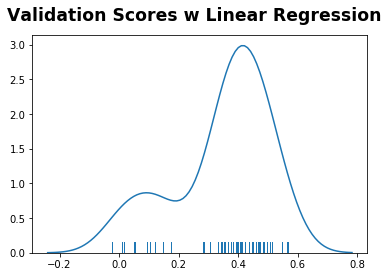

In [7]:
sns.distplot(scores,kde=True,hist=False,rug=True);
plt.suptitle("Validation Scores w Linear Regression",
            fontweight='bold',fontsize='xx-large'
            );

#### LASSO regularization doesn't save us

Often, folks fight over-fitting issues by "regularizing" their model -- adding in assumptions about what kinds of solutions should be found. Unfortunately, most standard regularization techniques won't help us. As an example, I chose LASSO regularization. The assumption of LASSO is that most parameters should be 0, with only a subset actually contributing. The size of that subset you expect to find is a hyperparameter.

In [8]:
scores = []

numSplits = 50

for split in range(numSplits):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,)
    model = sklearn.linear_model.Lasso()

    model.fit(X_train,y_train)

    scores.append(model.score(X_test,y_test))

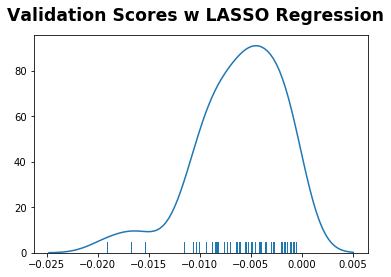

In [9]:
sns.distplot(scores,kde=True,hist=False,rug=True);
plt.suptitle("Validation Scores w LASSO Regression",
            fontweight='bold',fontsize='xx-large'
            );

## Aside: Looking at our residuals

It's helpful to take a look at our mistakes, especially when our models aren't working. Our mistakes are called residuals (they are the "residue" left over when we take out the component we've modeled). 

There's lots of information in the residuals -- they often tell us when our model is wildly incorrect in a way that the score, which is just a summary of the resiudals, can't.
Check out
[Anscombe's Quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)
for some examples.

The key thing for this little section is to realize that linear regression assumes that, once we've fit our model, the residuals look like a Gaussian distribution.

The cells below calculate the residuals for two models.
1. A model that just predicts the mean of each variable, ignoring the data. This is the "strawman" model that we use to calculate our $R^2$ score.
1. A linear regression model trained on 80% of the data.

They then store the residuals in a dataframe and plot them with `distplot`. I highly recommend someone pick through these (e.g. at the level of individual output variables). Also, this code is fairly portable, so I recommend you use it to visualize the residuals of any models you try.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,)
model = sklearn.linear_model.LinearRegression()

model.fit(X_train,y_train)

outputs = model.predict(X_test)
LR_residuals = y_test-outputs

In [11]:
means = np.mean(y_test,axis=0)

mean_residuals = y_test-means

results = pd.DataFrame(data=np.vstack([mean_residuals,LR_residuals]),
                       columns=output_columns
                      )

results['model'] = ['mean']*len(mean_residuals)+['LinearRegression']*len(LR_residuals)

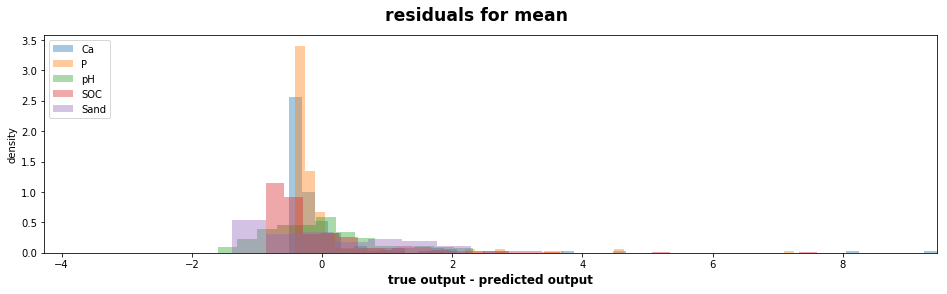

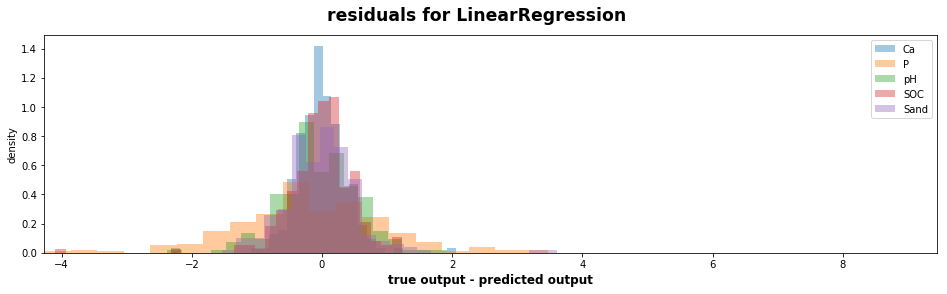

In [12]:
xMax = max(np.max(mean_residuals.as_matrix()),np.max(LR_residuals.as_matrix()))
xMin = min(np.min(mean_residuals.as_matrix()),np.min(LR_residuals.as_matrix()))

for model in ['mean','LinearRegression']:
    plt.figure(figsize=(16,4));
    plt.suptitle('residuals for '+model,
                 fontweight='bold',fontsize='xx-large'
                );
    for column in output_columns:
        sns.distplot(results[results.model==model][column],
                     hist=True,rug=False,kde=False,
                     hist_kws={'histtype':'stepfilled',
                              'normed':True,},
                     label=column
                    )
        plt.xlabel('true output - predicted output',
                  fontweight='bold',fontsize='large'
                  )
        plt.ylabel('density')
        
    plt.gca().set_xlim([xMin,xMax])
    plt.legend()